# Kalkulation der Bewegung einer Horizontalen Lenkung

In [1]:
from io import StringIO
from IPython.display import SVG, display

import numpy as np
import svgwrite
import sympy


def perpendicular(a):
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b


def normalize(a):
    return a / np.linalg.norm(a)


def vector_angle(p0, p1, p2):
    """Winkel zwischen den Vektoren gleichen Ursprungs
    p0 -> p1
    p0 -> p2
    """
    v0 = np.array(p1) - np.array(p0)
    v1 = np.array(p2) - np.array(p0)
    return np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1))


def distance(p0, p1):
    return np.sqrt((p0[0] - p1[0]) ** 2 + (p0[1] - p1[1]) ** 2)


def middle(p0, p1):
    return p0 + (p1 - p0) / 2.0


class Steering(object):
    def __init__(self, outer_width, inner_width, depth, wheel_diameter, axis_offset=None):
        self.wheel_diameter = wheel_diameter
        self.inner_width = inner_width
        self.hinge_outer_left = np.array([0.0, 0.0])
        self.hinge_outer_right = np.array([outer_width, 0.0])
        self.middle_straight = np.array([outer_width / 2.0, depth])
        self.leg_angle_straight = vector_angle(
            self.hinge_outer_left, self.hinge_outer_right, self.middle_straight
        )
        self.leg_radius = (outer_width / 2.0 - inner_width / 2.0) / np.cos(
            self.leg_angle_straight
        )
        if axis_offset is not None:
            self.axis_offset = axis_offset
        else:
            self.axis_offset = distance(self.middle_straight, self.middle)
        self._left_angle = self.leg_angle_straight
        self._cache = {}
        
    def _get_cache(self, key, default):
         return self._cache.get(key, default)

    def _set_cache(self, key, value):
         self._cache[key] = value

    @property
    def left_angle(self):
        return getattr(self, "_left_angle", self.leg_angle_straight)

    @left_angle.setter
    def left_angle(self, value):
        old_value = self._left_angle
        self._left_angle = value        
        self._cache = {}
        try:
            foo = self.hinge_inner_right
        except IndexError:
            self._left_angle = old_value
            raise ValueError("Angle out of motion constraints.")
        if self.wheel_collision:
            self._left_angle = old_value
            raise ValueError("Wheel collides with leg")        

    @property
    def middle(self):
        value = self._get_cache("middle", None)
        if value is not None:
            return value        
        value = middle(self.hinge_inner_left, self.hinge_inner_right)
        self._set_cache("middle", value)
        return value

    @property    
    def hinge_inner_left(self):
        value = self._get_cache("hinge_inner_left", None)
        if value is not None:
            return value        
        value = np.array(
            [
                self.leg_radius * np.cos(self.left_angle),
                self.leg_radius * np.sin(self.left_angle),
            ]
        )
        self._set_cache("hinge_inner_left", value)
        return value

    @property
    def hinge_inner_right(self):
        value = self._get_cache("hinge_inner_right", None)
        if value is not None:
            return value
        axis_circle = sympy.geometry.ellipse.Circle(
            sympy.Point(self.hinge_inner_left), self.inner_width
        )
        leg2_circle = sympy.geometry.ellipse.Circle(
            sympy.Point(self.hinge_outer_right), self.leg_radius
        )
        value = np.array(axis_circle.intersection(leg2_circle)[1]).astype(
            np.float64
        )
        self._set_cache("hinge_inner_right", value)
        return value

    @property
    def axis_angle(self):
        value = self._get_cache("axis_angle", None)
        if value is not None:
            return value
        v0 = np.array(self.hinge_inner_left) - np.array(self.hinge_inner_right)
        v1 = np.array(self.hinge_outer_left) - np.array(self.hinge_outer_right)
        value = np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1))
        self._set_cache("axis_angle", value)
        return value

    @property
    def axis_middle(self):
        value = self._get_cache("axis_middle", None)
        if value is not None:
            return value        
        if self.axis_offset:
            
            value = (
                self.middle
                + perpendicular(normalize(self.hinge_inner_right - self.middle))
                * self.axis_offset
            )
        else:
            value = self.middle
        self._set_cache("axis_middle", value)
        return value

    @property
    def wheel(self):
        value = self._get_cache("wheel", None)
        if value is not None:
            return value        
        p = perpendicular(normalize(self.hinge_inner_right - self.middle))
        nose = self.axis_middle + p * (self.wheel_diameter / 2)
        tail = self.axis_middle - p * (self.wheel_diameter / 2)
        value = nose, tail
        self._set_cache("wheel", value)
        return value

    @property
    def wheel_collision(self):
        value = self._get_cache("wheel_collision", None)
        if value is not None:
            return value        
        wheel = sympy.geometry.line.Segment(*self.wheel)
        leg = sympy.geometry.line.Segment(
            self.hinge_inner_right, self.hinge_outer_right
        )
        value = bool(wheel.intersection(leg))
        self._set_cache("wheel_collision", value)
        return value
    
    def limit(self, iterations=7):
        """limit of steering angle"""
        old_angle = self.left_angle
        low = 0.0001
        high = self.leg_angle_straight
        val = -1
        for idx in range(0, iterations):
            # print(idx, low, high, val)
            mid = low + (high-low) / 2
            self.left_angle = high
            val = self.axis_angle
            try:
                self.left_angle = low
                val = self.axis_angle
            except ValueError:
                # check mid
                try:
                    self.left_angle = mid
                    val = self.axis_angle
                except ValueError:
                    low = mid
                    continue
                high = mid
                continue
            break
        self.left_angle = old_angle
        return val
                
    
    # plotting specific below

    output_offset = 40

    @property
    def output_bottom(self):
        return (self.middle_straight[1] + self.wheel_diameter / 3) + self.output_offset

    def plot_coord(self, p):
        # transform to scaled cartesic I
        return (
            self.output_scale * (self.output_offset + p[0]),
            self.output_scale * (self.output_bottom - p[1]),
        )

    def svg_text(self, p, text, size=15, h=0, v=0):
        if h:
            p[0] = p[0] + self.output_scale * h
        if v:
            p[1] = p[1] - self.output_scale * v
        return self._dwg.text(
            text,
            insert=self.plot_coord(p),
            stroke="none",
            fill=svgwrite.rgb(),
            font_size=f"{size}px",
            font_family="Arial",
        )

    def svg_line(self, p0, p1):
        return self._dwg.line(start=self.plot_coord(p0), end=self.plot_coord(p1))

    def svg_circle(self, p0, radius):
        return self._dwg.circle(self.plot_coord(p0), self.output_scale * radius)

    def plot_init(self, scale=1, show_text=False):
        self.output_scale = scale
        self._dwg = dwg = svgwrite.Drawing(
            debug=True,
            size=(
                self.output_scale
                * (self.hinge_outer_right[0] + 4 * self.output_offset),
                self.output_scale * (self.output_bottom + self.output_offset),
            ),
        )
        lgray = dwg.add(dwg.g(id="red", stroke="lightgray", fill="white"))
        lgray["fill-opacity"] = "0.33"
        self._green = green = dwg.add(dwg.g(id="green", stroke="green"))
        green["fill-opacity"] = "0.33"
        self._red = red = dwg.add(dwg.g(id="red", stroke="red"))
        red["fill-opacity"] = "0.2"
        self._blue = blue = dwg.add(dwg.g(id="blue", stroke="blue"))
        blue["fill-opacity"] = "0.25"
        self._violett = dwg.add(dwg.g(id="blue", stroke="violet"))
        self._violett["fill-opacity"] = "0.1"

        # draw initial
        lgray.add(self.svg_line(self.middle_straight, [self.middle_straight[0], 0]))
        lgray.add(self.svg_circle(self.middle_straight, 5))
        lgray.add(self.svg_line(self.hinge_outer_left, self.hinge_outer_right))
        blue.add(self.svg_circle(self.hinge_outer_left, 5))
        blue.add(self.svg_circle(self.hinge_outer_right, 5))
        if show_text:
            dwg.add(
                self.svg_text(
                    middle(self.hinge_outer_left, self.hinge_outer_right),
                    f"given outer width={distance(self.hinge_outer_left, self.hinge_outer_right):0.1f}",
                    h=5,
                    v=-3,
                )
            )
            dwg.add(
                self.svg_text(
                    middle(self.hinge_inner_left, self.hinge_inner_right),
                    f"given inner width={distance(self.hinge_inner_left, self.hinge_inner_right):0.1f}",
                    h=5,
                    v=-3,
                )
            )
            dwg.add(
                self.svg_text(
                    middle(self.hinge_outer_left, self.hinge_inner_left),
                    f"leg={distance(self.hinge_outer_left, self.hinge_inner_left):0.1f}",
                )
            )
            dwg.add(
                self.svg_text(
                    self.wheel[0],
                    f"given diameter={self.wheel_diameter:0.1f}",
                    h=5,
                    v=3,
                )
            )
            if self.axis_offset:
                dwg.add(
                    self.svg_text(
                        self.axis_middle, f"axis offset={self.axis_offset:0.1f}", h=5, v=-7
                    )
                )

    def plot_state(self):
        dwg = getattr(self, "_dwg", None)
        red = self._red
        violett = self._violett
        green = self._green
        blue = self._blue
        green.add(self.svg_line(self.hinge_outer_left, self.hinge_inner_left))
        green.add(self.svg_line(self.hinge_outer_right, self.hinge_inner_right))
        green.add(self.svg_line(self.hinge_inner_left, self.hinge_inner_right))

        blue.add(self.svg_circle(self.hinge_inner_left, 3))
        dwg.add(
            self.svg_text(
                self.hinge_inner_left, f"{np.rad2deg(self.axis_angle):0.1f}°", h=5
            )
        )
        blue.add(self.svg_circle(self.hinge_inner_right, 3))
        # axis offset
        if self.axis_offset:
            violett.add(self.svg_line(*self.wheel))
            red.add(self.svg_circle(self.axis_middle, 3))

    def output(self):
        sio = StringIO()
        self._dwg.write(sio)
        data = sio.getvalue()
        display(SVG(data=data))

    def plot_one(self, scale=1):
        self.plot_init(scale=scale, show_text=True)
        self.plot_state()
        self.output()

    def plot_and_output_series(self, quantity=10, scale=1.8):
        self.left_angle = self.leg_angle_straight
        self.plot_init(scale=scale)
        self.plot_state()
        for angle in reversed(
            np.linspace(0.01, np.rad2deg(self.leg_angle_straight) - 0.01, quantity)
        ):
            try:
                self.left_angle = np.deg2rad(angle)
            except ValueError as e:
                self._dwg.add(
                    self.svg_text(
                        middle(self.hinge_outer_left, self.hinge_outer_right),                        
                        f"left leg at {angle:0.2f}°: {e.args[0]}",
                        h=-100,
                        v=-5,
                    )
                )
                break
            self.plot_state()
        self._dwg.add(
            self.svg_text(
                self.wheel[1],
                f"{np.rad2deg(self.axis_angle):0.1f}° steering",
                h=-5,
                v=-2
            )
        )
        self.output()


In [ ]:
def optimize_steering(width, depth, offset, steps):
    values = []
    for w in np.linspace(width[0], width[1], steps):
        for d in np.linspace(depth[0], depth[1], steps):
            for o in np.linspace(offset[0], offset[1], steps):
                steering = Steering(w, 100.0, depth=d, wheel_diameter=250, axis_offset=o)
                limit = steering.limit()
                values.append((w, d, o, limit))
                if -np.rad2deg(limit) > 70:
                    print(f"l={np.rad2deg(limit):0.2f}°, w={w:0.1f}, d={d:0.1f}, o={o:0.1f}")
    return values

result = optimize_steering(width=(280.0, 400.0), depth=(180, 220), offset=(-60, 0), steps=4)

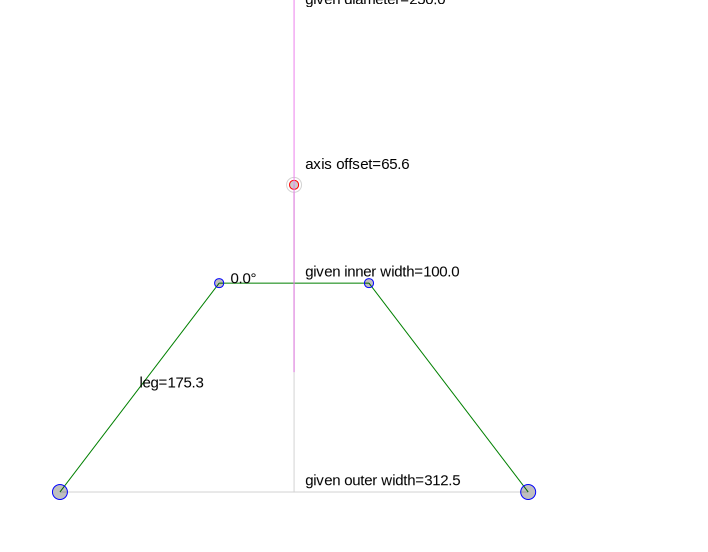

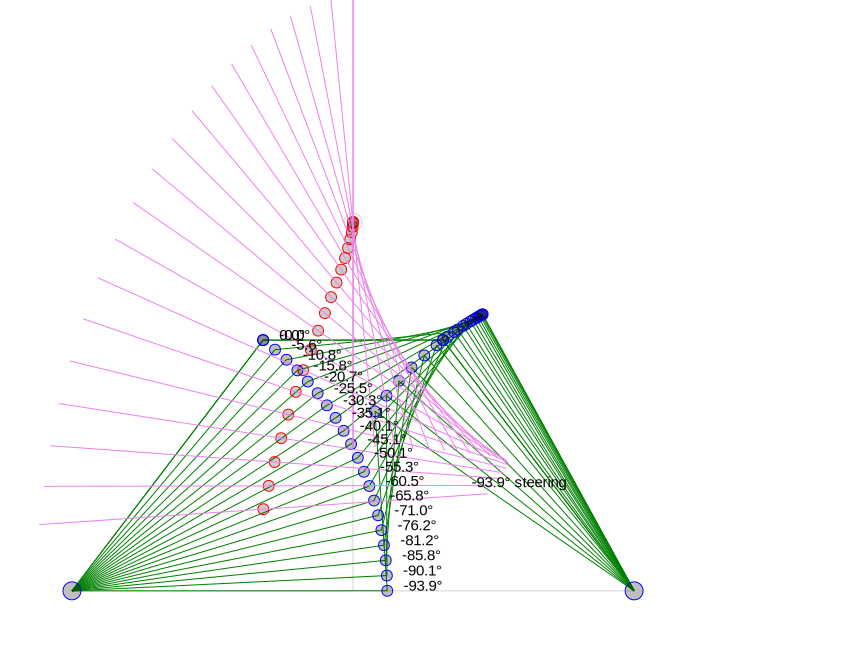

In [56]:
steering = Steering(312.5, 100.0, depth=205.0, wheel_diameter=250, axis_offset=0)
steering.plot_one(scale=1.5)
steering.plot_and_output_series(quantity=20)
